# STEP33 ニュートン方を使った最適化(自動計算)

## これまでの流れ

- STEP27:テイラー展開の微分
- STEP28:ローゼンブロック関数を勾配降下法を理解する
- STEP29:ニュートン法を用いた最適化, 勾配法は遅いのでニュートン法による収束高速化を目指す
- STEP30:Back propagation の実装を見直して2階微分, 3階微分など高階微分に対応できるようにする(準備)
- STEP31:Back propagation の実装を見直して2階微分, 3階微分など高階微分に対応できるようにする(理論)
- STEP32:Back propagation の実装を見直して2階微分, 3階微分など高階微分に対応できるようにする(実装)
- STEP33:ニュートン法は2階微分を使うので、STEP30〜STEP32までの成果を使って自動に最適化計算を行ってみる

## STEP33の目的

- STEP32で実装した機能を用いて、簡単な計算を２階微分を用いて計算する。続いてニュートン法を使った最適化を行う

## 事前準備

`dezero/__init__.py` の `is_simple_core = False` であることを確認すること

In [1]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from dezero import Variable

## 33.1 ２階微分を求める

ここでは、$y = x^4 - 2x^2$ を扱う (教科書の説明では"+"になっているがプログラムは"-"になっていることに注意。教科書の説明に間違いあり)

このとき

- $dy/dx = 4x^3 - 4x$
- $d^2y/dx^2 = 12x^2 - 4$

よって、$x = 2$ のとき

- $ y = 16 - 8 = 8 $
- $ dy/dx = 32 - 8 = 24 $
- $ d^2y/dx^2 = 48 - 4 = 44$



<function matplotlib.pyplot.show(close=None, block=None)>

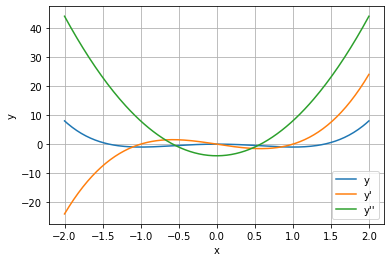

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-2,2,200)
y1 = x**4 - 2 * x**2
y2 = 4*x**3 - 4 * x
y3 = 12*x**2 - 4

plt.plot(x, y1, label="y")
plt.plot(x, y2, label="y'")
plt.plot(x, y3, label="y''")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show

### `x.cleargrad()`を入れないとx=2で２階微分が44にならず68になることに注意

下記プログラムだと、1階微分の値と、2階微分の値の足し算となって68となっている

- 1階微分 = 24
- 2階微分 = 44

In [3]:
#
# 対象となる関数の作成
#
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

x = Variable(np.array(2.0))
y = f(x)

# 1回目逆伝搬
y.backward(create_graph=True)
print(x.grad)

gx = x.grad

# 2回目逆伝搬
gx.backward()
print(x.grad)

variable(24.0)
variable(68.0)


### 2回目の逆伝搬の前に`x.cleargrad()`をいれてやることで上記問題を解決する

In [4]:
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

x = Variable(np.array(2.0))
y = f(x)

# 1回目逆伝搬
y.backward(create_graph=True)
print(x.grad)

gx = x.grad

# ここで、現状のx.gradをきれいにしてやる
x.cleargrad()

# 2回目逆伝搬
gx.backward()
print(x.grad)

variable(24.0)
variable(44.0)


## 33.2 ニュートン法による最適化

### テーラー展開

$$
f\left(x\right)=\sum_n^\infty\frac{f^{n}\left(a\right)}{n!}\left(x-a\right)^n=f\left(a\right)+f^\prime\left(a\right)\left(x-a\right)+\frac{f^{\prime\prime}\left(a\right)}{2!}\left(x-a\right)^2+\frac{f^{\prime\prime\prime}\left(a\right)}{3!}\left(x-a\right)^3+...
$$

### 2次の項で打ち切った場合

$$
f\left(x\right)=f\left(a\right)+f^\prime\left(a\right)\left(x-a\right)+\frac{f^{\prime\prime}\left(a\right)}{2!}\left(x-a\right)^2
$$

### この2次関数の傾きがゼロになる点を求める

$$
\begin{align}
& \frac{\text{d}}{\text{d}x} \left(f\left(a\right)+f^\prime\left(a\right)\left(x-a\right)+\frac{f^{\prime\prime}\left(a\right)}{2!}\left(x-a\right)^2 \right) = 0 \\
& f^\prime\left(a\right)+f^{\prime\prime}\left(a\right)(x-a)=0 \\
& x=a - \frac{f^\prime\left(a\right)}{f^{\prime\prime}\left(a\right)}
\end{align}
$$

### 一般的に書くと

$$
x_{next}\leftarrow x_{now}-\frac{f^\prime\left(x_{now}\right)}{f^{\prime\prime}\left(x_{now}\right)}
$$

In [5]:
# 想定した関数
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

# 入力
x = Variable(np.array(2.0))
iters = 10

# グラフ化のための箱
x_iter = []
y_iter = []

for i in range(iters):
    print(i, x)
    y = f(x)

    x_iter.append(float(x.data))
    y_iter.append(float(y.data))
    x.cleargrad()
    # 1階微分
    y.backward(create_graph=True)

    gx = x.grad
    x.cleargrad()
    
    # 2階微分
    gx.backward()
    gx2 = x.grad

    x.data -= gx.data / gx2.data
    # 従来
    # lr = 0.02
    # x.data -= lr * gx.data

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


<function matplotlib.pyplot.show(close=None, block=None)>

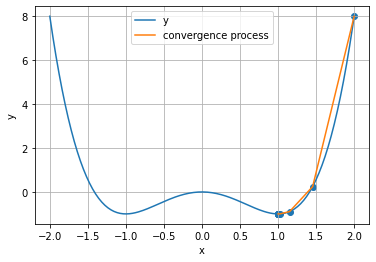

In [6]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-2,2,200)
#x = np.linspace(0.5,2,200)
y1 = x**4 - 2 * x**2

plt.plot(x, y1, label="y")
plt.scatter(x_iter, y_iter)
plt.plot(x_iter, y_iter, label="convergence process")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show